In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats

import seaborn as sns
#sns.set()
sns.set(color_codes=True)

# Gaussian/Normal distribution

In the first lab we used a normal distribution, let's look at plotting a normal distribution's PDF. Remember the normal (Gaussian) distribution is defined as

$$p(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).$$

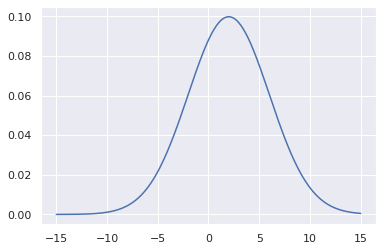

In [3]:
def gaussian(x, mean, stdev):
    return np.exp(-((x-mean)**2)/(2*stdev**2))/(np.sqrt(2*np.pi)*stdev)

x = np.linspace(-15, 15, 250)
plt.plot(x, gaussian(x, 2, 4))

Text(0.5, 1.0, 'Area under the curve gives probability -- here 90% probability limits')

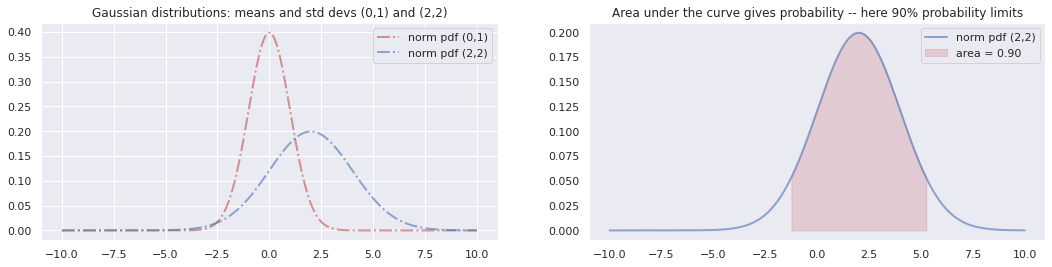

In [4]:
# create grid of 150 points from -3, 5
x = np.linspace(-10, 10, 250)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].plot(x, stats.norm.pdf(x), 'r-.', lw=2, alpha=0.6, label='norm pdf (0,1)')
ax[0].plot(x, stats.norm.pdf(x, 2, 2), 'b-.', lw=2, alpha=0.6, label='norm pdf (2,2)')
ax[0].legend()
ax[0].set_title("Gaussian distributions: means and std devs (0,1) and (2,2)")
x_90_idx = (x > stats.norm.ppf(0.05, 2, 2)) & (x < stats.norm.ppf(0.95, 2, 2))
ax[1].grid(False)
ax[1].plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6,  label='norm pdf (2,2)')
ax[1].fill_between(x[x_90_idx], stats.norm.pdf(x[x_90_idx], 2, 2), color='r', alpha=.2, label='area = 0.90')
ax[1].legend()
ax[1].set_title("Area under the curve gives probability -- here 90% probability limits")